In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install arabic-reshaper


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install python-bidi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import gensim
import re
import math
import numpy as np
import pandas as pd
from nltk import ngrams
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
import csv
from collections import OrderedDict
import arabic_reshaper
from bidi.algorithm import get_display
import pickle

In [5]:
#load all models
directory="/content/drive/My Drive/Research/"
models={}
models["cbow-wiki"]=gensim.models.Word2Vec.load('/content/drive/My Drive/Research/cbow-wiki/full_grams_cbow_300_wiki.mdl')
models["cbow-twitter"]=gensim.models.Word2Vec.load('/content/drive/My Drive/Research/cbow-twitter/full_grams_cbow_300_twitter.mdl')



In [6]:
print(models.keys())

dict_keys(['cbow-wiki', 'cbow-twitter'])


In [7]:
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!',"ة"]
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ',"ه"]
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text



In [8]:
def get_count(token,vectors):
    if token in vectors:
        return vectors.vocab[token].count
    else:
        return 0


def get_vocab(token,vectors):
    if token in vectors:
      return vectors.vocab[token].count , vectors[token]
    else:
      return 0,np.zeros(300)

def cos_sim(emb1, emb2):
    return((emb1/np.linalg.norm(emb1)).dot(emb2/np.linalg.norm(emb2)))

#### **GENDER VECTOR**

In [9]:
def gender_vector(pairs, vectors,n_components=1):
    N= len(pairs)

    mat= np.zeros((2*N,300),np.float64)
    for i in range(N):
        
        if(pairs[i][0] in vectors and pairs[i][1] in vectors):
            m_vector=vectors[pairs[i][0]]
            f_vector=vectors[pairs[i][1]]
        elif(clean_str(pairs[i][0]) in vectors and clean_str(pairs[i][1]) in vectors):
            m_vector=vectors[clean_str(pairs[i][0])]
            f_vector=vectors[clean_str(pairs[i][1])]
            
        elif(clean_str(pairs[i][0]) in vectors and pairs[i][1] in vectors):
            m_vector=vectors[clean_str(pairs[i][0])]
            f_vector=vectors[pairs[i][1]]
            
        elif(pairs[i][0] in vectors and clean_str(pairs[i][1]) in vectors):
            m_vector=vectors[pairs[i][0]]
            f_vector=vectors[clean_str(pairs[i][1])]
            
        center=(f_vector+m_vector)/2
        mat[2*i]=f_vector-center
        mat[2*i+1]=m_vector-center

      


    pca = PCA(n_components = n_components)
    mat2=pca.fit_transform(mat.transpose())
#     plt.bar(range(n_components), pca.explained_variance_ratio_)
    return  mat2.flatten()
    


# **Bias Test**

In [10]:
def group_bias(g,male_words,female_words,vectors):
    N=len(male_words)
    total=0.0
    for i in range(len(male_words)):
        if(male_words[i] in vectors and female_words[i] in vectors):
            b=word_bias(g,male_words[i],female_words[i],vectors)
        elif(clean_str(male_words[i]) in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,clean_str(male_words[i]),clean_str(female_words[i]),vectors)
        elif(clean_str(male_words[i]) in vectors and female_words[i] in vectors):
            b=word_bias(g,clean_str(male_words[i]),female_words[i],vectors)
        elif(male_words[i] in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,male_words[i],clean_str(female_words[i]),vectors)
        else:
            continue
        if not math.isnan(b):
            total=total+b
    total=total/N
    return total

In [11]:
def group_bias_details(g,male_words,female_words,vectors):
    N=len(male_words)
    total=0.0
    for i in range(len(male_words)):
        if(male_words[i] in vectors and female_words[i] in vectors):
            b=word_bias_details(g,male_words[i],female_words[i],vectors)
        elif(clean_str(male_words[i]) in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias_details(g,clean_str(male_words[i]),clean_str(female_words[i]),vectors)
        elif(clean_str(male_words[i]) in vectors and female_words[i] in vectors):
            b=word_bias_details(g,clean_str(male_words[i]),female_words[i],vectors)
        elif(male_words[i] in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias_details(g,male_words[i],clean_str(female_words[i]),vectors)
        else:
            continue
        if not math.isnan(b):
            total=total+b
    total=total/N
    return total

In [12]:
def getBias (male_words,female_words,vectors):
    
    biases=[]
    b=0
    for i in range(len(male_words)):
        if(male_words[i] in vectors and female_words[i] in vectors):
            b=word_bias(g,male_words[i],female_words[i],vectors)
        elif(clean_str(male_words[i]) in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,clean_str(male_words[i]),clean_str(female_words[i]),vectors)
        elif(clean_str(male_words[i]) in vectors and female_words[i] in vectors):
            b=word_bias(g,clean_str(male_words[i]),female_words[i],vectors)
        elif(male_words[i] in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,male_words[i],clean_str(female_words[i]),vectors)
        biases.append(b)
    return biases
    

In [13]:
def word_bias(g,male,female,vectors):
    m=get_vocab(male,vectors)
    f=get_vocab(female,vectors)
    average=(m[0]*cos_sim(m[1],g) + f[0]*cos_sim(f[1],g)) / (m[0]+f[0])
#     print(average," : ",male,"-",female)
#     average=(cos_sim(m[1],g) + cos_sim(f[1],g)) / 2
    return average

In [14]:
def word_bias_details(g,male,female,vectors):
    m=get_vocab(male,vectors)
    f=get_vocab(female,vectors)
    average=(m[0]*cos_sim(m[1],g) + f[0]*cos_sim(f[1],g)) / (m[0]+f[0])
    print(average," : ",male,"-",female)
    # average=(cos_sim(m[1],g) + cos_sim(f[1],g)) / 2
    return average

In [15]:
#Horizontal
def plotBar(row,col,title,xLabel,yLabel,location):
    colors=['b','m','y','r']
    new_col = [ ]

    for item in col:
        new_col.append(get_display(arabic_reshaper.reshape(item)))
    # creating the bar plot
    y=np.arange(len(col))   
    x=row  
    plt.rcdefaults()
    fig, ax = plt.subplots()
    barlist=ax.barh(y, x, align='center')
    for b in range(len(barlist)):
      if x[b] < 0:
        barlist[b].set_color(colors[0])
      elif x[b]==0:
        barlist[b].set_color(colors[2])
      else:
        barlist[b].set_color(colors[3])
    ax.set_yticks(y)
    ax.set_yticklabels(new_col)
    ax.invert_yaxis()  
    ax.set_ylabel(yLabel)
    ax.set_xlabel(xLabel)
    ma=max(x)
    mi=abs(min(x))
    lim=ma
    if ma < mi:
        lim=mi
    ax.set_xlim([-lim*1.2, lim*1.2])
    ax.set_title(title)
    ax.grid(color='grey', linestyle='dotted', linewidth=0.3)
    
    # fig.show()
    fig.savefig(location)


# **Generating Names**


In [16]:
nouns=[("هو","هي"),("اب","ام"),("هم","هن"),("ولد","بنت"),("عليه","عليها"),("اخ","اخت"),("به","بها"), ("رجل","امراة"),("سيد","سيدة"),("ذكر","انثى"),("صبي","صبية"),("صبيان","صبايا"),("شباب","بنات"), ("عنه","عنها"),("له","لها")]

# Categories

In [17]:
categories={}

#Strength
StrengthM=["جهد","قوة","قدرة","قدرات","طاقة","فاعلية","كفاءة","قوي","جدارة","فعال","مجتهد","يجتهد"]
StrengthF=["جهد","قوة","قدرة","قدرات","طاقة","فاعلية","كفاءة","قوية","جدارة","فعالة","مجتهدة","تجتهد"]
categories["Strength"]={"male":StrengthM,"female":StrengthF}

#Weakness
WeaknessM=["مرهق","متعب","ضعف","متذمر","مجروح"]
WeaknessF=["مرهقة","متعبة","ضعف","متذمرة","مجروحة"]
categories["Weakness"]={"male":WeaknessM,"female":WeaknessF}

#Career
CareerM=["مهنة", "تجارة", "عمل","مكتب","معاش","راتب","محاسب","مؤسسة", "مصمم", "مدير", "مشرف", "وظيفة","تدريب","يتدرب","طبيب","موظف","ممرض","تقاعد", "أخصائي", "ممثل","فنان","سكرتير","كاتب","شغل","محامي","اعمال"]
CareerF=["مهنة", "تجارة", "عمل","مكتب","معاش","راتب","محاسبة","مؤسسة", "مصممة", "مديرة", "مشرفة", "وظيفة","تدريب","تتدرب","طبيبة","موظفة","ممرضة","تقاعد", "أخصائية", "ممثلة","فنانة","سكرتيرة","كاتبة","شغل","محامية","اعمال"]
categories["Career"]={"male":CareerM,"female":CareerF}

#Family
FamilyM=["طلاق","طفل","طفولة","ولد","زوج","زواج","عم","خال","زوج","يربي","اب","أقارب","أسرة","عائلة"]
FamilyF=["طلاق","طفلة","طفولة","بنت","زوجة","زواج","عمة","خالة","زوجة","تربي","ام","أقارب","أسرة","عائلة"]
categories["Family"]={"male":FamilyM,"female":FamilyF}

#DomesticWork
DomesticWorkM=["مهمة","خبز","طبخ","مطبخ","يطبخ","ينظف", "متسخ","مرتب","تنشيف"]
DomesticWorkF=["مهمة", "خبز","طبخ","مطبخ","تطبخ","تنظف", "متسخ","مرتب","تنشيف"]
categories["DomesticWork"]={"male":DomesticWorkM,"female":DomesticWorkF}


#Science

ScienceM=["هندسة", "كيمياء", "بيانات","رياضيات","علم","طب","عالم","اكتشاف","يكتشف","أحياء","فيزياء", "ابتكار","علوم","اختراع","يخترع","كمبيوتر","حاسوب","معمل", "بحث", "باحث","مهندس","دكتوراة","دكتور","طبيب","مخترع"]
ScienceF=["هندسة", "كيمياء", "بيانات","رياضيات","علم","طب","عالمة","اكتشاف","تكتشف","أحياء","فيزياء", "ابتكار","علوم","اختراع","تخترع","كمبيوتر","حاسوب","معمل", "بحث", "باحثة","مهندسة","دكتوراة","دكتورة","طبيبة","مخترعة"]
categories["Science"]={"male":ScienceM,"female":ScienceF}

#Art
ArtM=["إبداع", "مبدع", "فني","فنان","معرض","تصوير","مصور","رسم","رسام","تلوين","مسرح","نحت", "نحات", "مزخرف","موهبة","موهوب","موسيقى","أغنية","رقص","تصميم","مصمم", "تزيين","فن","غناء","أزياء","طرب","مطرب"]
ArtF=["إبداع", "مبدعة", "فني","فنانة","معرض","تصوير","مصورة","رسم","رسامة","تلوين","مسرح","نحت", "نحاتة", "مزخرف","موهبة","موهوبة","موسيقى","أغنية","رقص","تصميم","مصممة", "تزيين","فن","غناء","أزياء","طرب","مطربة"]
categories["Art"]={"male":ArtM,"female":ArtF}

#Money & Business
MoneyAndBusinessM=["بنك", "مصرف", "ديون","مليونير","بضائع","مال","مصاري","دولار","يورو","ليرة","تجارة","محاسب", "شيكات", "راتب","قرض","ميزانية","مشروع","ثروة","شيك","تمويل","صفقة","إستثمار","ربح", "أعمال","مشروع","إقتصاد","شراكة","تسويق","مدير","صناعة"]
MoneyAndBusinessF=["بنك", "مصرف", "ديون","مليونيرة","بضائع","مال","مصاري","دولار","يورو","ليرة","تجارة","محاسبة", "شيكات", "راتب","قرض","ميزانية","مشروع","ثروة","شيك","تمويل","صفقة","إستثمار","ربح", "أعمال","مشروع","إقتصاد","شراكة","تسويق","مديرة","صناعة"]
categories["MoneyAndBusiness"]={"male":MoneyAndBusinessM,"female":MoneyAndBusinessF}


#beauty & appearance
BeautyAndAppearanceM=["فاتن", "أناقة","جمال","جذاب","معجب","مذهل","طويل","قصير","وزن","أشقر", "أنيق", "أسمر","بشرة","تسريحة","مثير","لياقة","لباس", "شهوة", "قبلة","رومانسي","يتغزل","ملفت","يرتدي"]
BeautyAndAppearanceF=["فاتنة", "أناقة","جمال","جذابة","معجبة","مذهلة","طويلة","قصيرة","وزن","شقراء","أنيقة","سمراء","بشرة","تسريحة","مثيرة","لياقة","لباس", "شهوة","قبلة","رومانسي","تتغزل","ملفت","يرتدي"]
categories["BeautyAndAppearance"]={"male":BeautyAndAppearanceM,"female":BeautyAndAppearanceF}

#Validation
len(categories)

for c in categories:
    if len(categories[c]["male"]) != len(categories[c]["female"]): 
                                               print(c)


# Running Bias Test

In [18]:
df = pd.DataFrame(columns = ['Model']+list(categories.keys()))
for n in models:
    
              
    vectors=models[n].wv
    row=[]
    row.append(n)
    
    
    g=gender_vector(nouns,vectors)
    for c in categories:
        bias=group_bias_details(g,categories[c]["male"],categories[c]["female"],vectors)
        row.append(bias)
        print("-------------------------------------------")
    df.loc[len(df.index)]=row
        


0.0863355873325361  :  جهد - جهد
-0.10242751363870108  :  قوه - قوه
-0.05332389661556868  :  قدره - قدره
-0.12556265665097138  :  قدرات - قدرات
-0.0707767199629157  :  طاقه - طاقه
-0.10627536711451342  :  فاعليه - فاعليه
-0.13806070956907754  :  كفاءه - كفاءه
-0.05365554107619495  :  قوي - قويه
0.022884779435062206  :  جداره - جداره
-0.07772303293713605  :  فعال - فعاله
0.26940949346770404  :  مجتهد - مجتهده
0.08684455223880681  :  يجتهد - تجتهد
-------------------------------------------
-0.18065497291489588  :  مرهق - مرهقه
0.04139662513160527  :  متعب - متعبه
-0.0331770522661219  :  ضعف - ضعف
-0.09042079751155163  :  متذمر - متذمره
-------------------------------------------
-0.05438533275416299  :  مهنه - مهنه
-0.06519944045935995  :  تجاره - تجاره
0.1147521970805641  :  عمل - عمل
0.0634500068009242  :  مكتب - مكتب
-0.011364537037010694  :  معاش - معاش
0.09059145852680008  :  راتب - راتب
0.06063515797400193  :  محاسب - محاسبه
-0.13753262567342095  :  مؤسسه - مؤسسه
-0.03414741174272

In [19]:
display(df)

,Model,Strength,Weakness,Career,Family,DomesticWork,Science,Art,MoneyAndBusiness,BeautyAndAppearance
0,cbow-wiki,-0.021861,-0.052571,0.061083,-0.020131,0.004533,0.081518,0.026094,-0.010699,-0.042158
1,cbow-twitter,-0.021906,0.000923,-0.046532,0.092611,0.020702,-0.012653,0.023859,-0.019126,0.087099


In [20]:
with open(directory+'/cbow.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Results

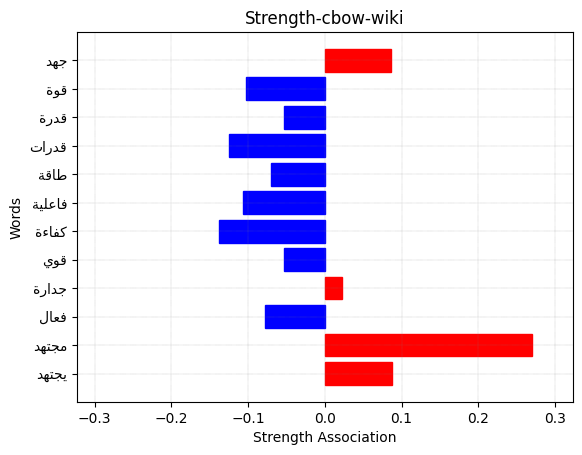

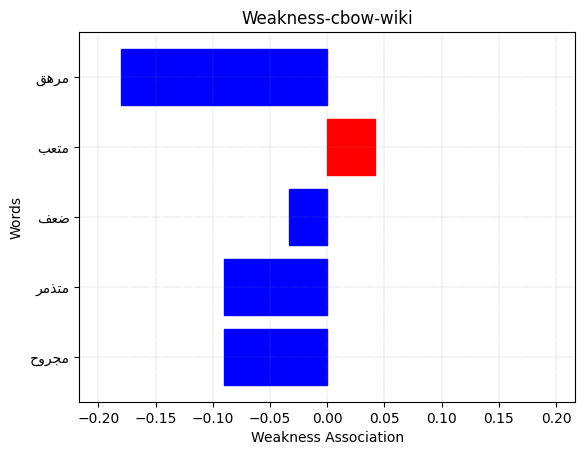

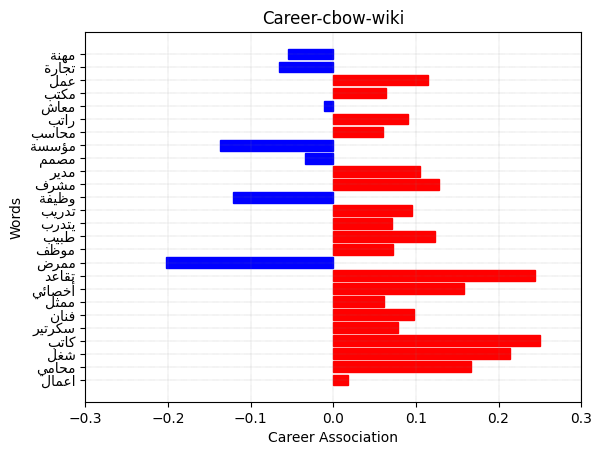

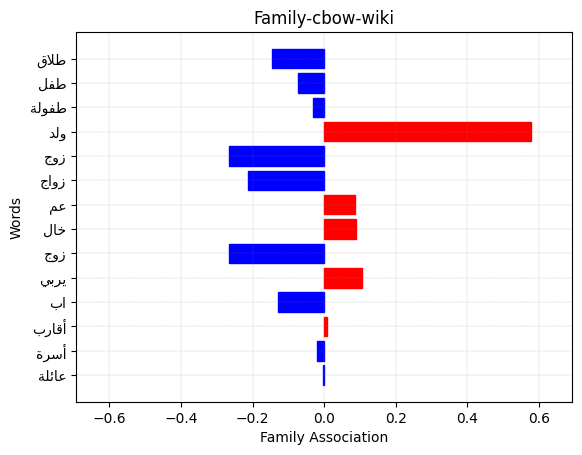

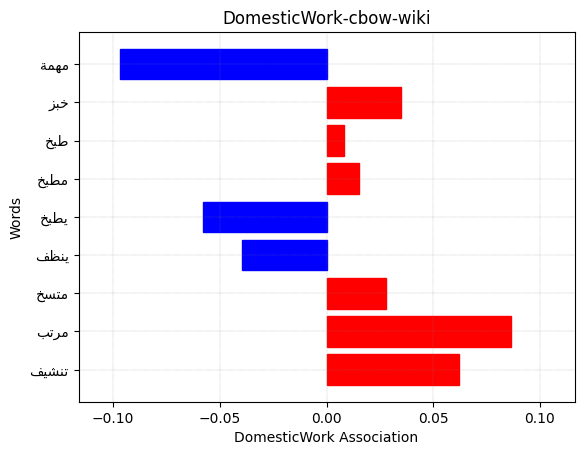

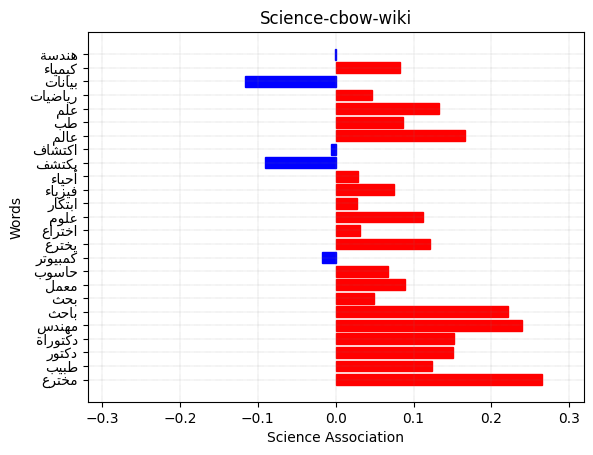

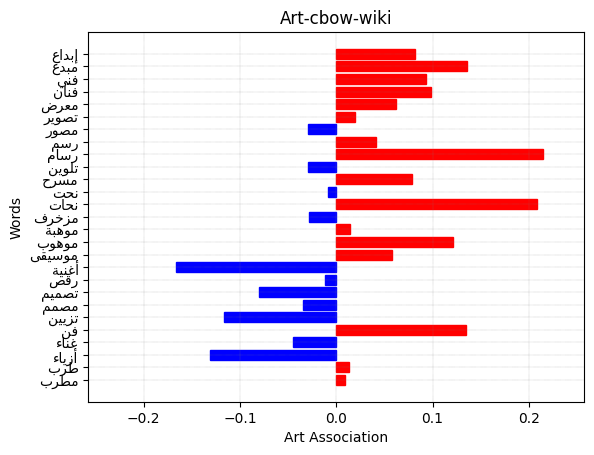

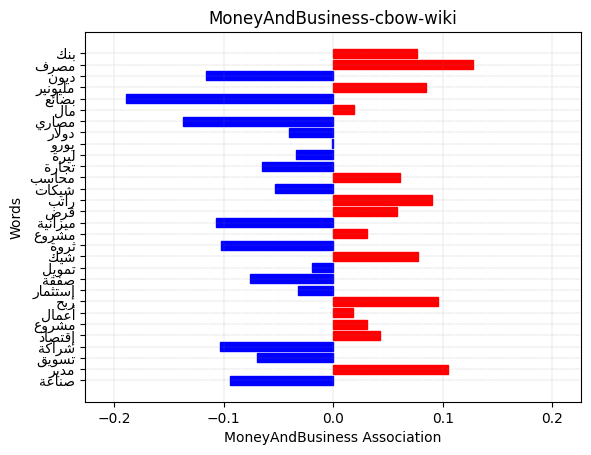

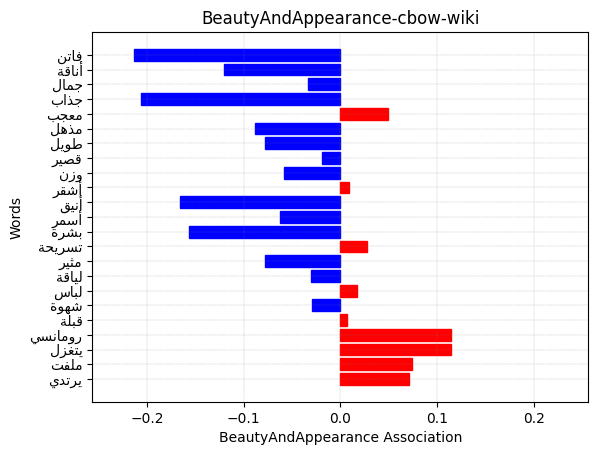

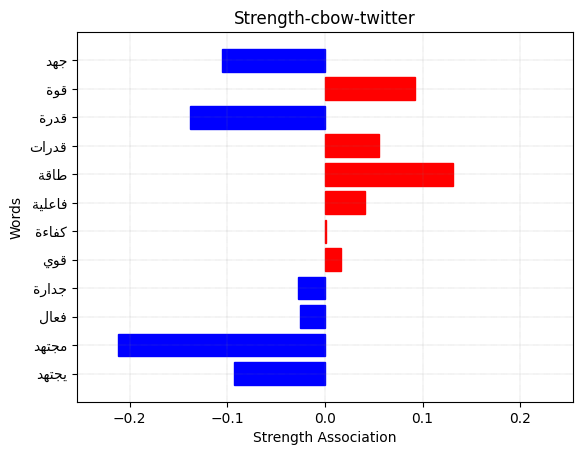

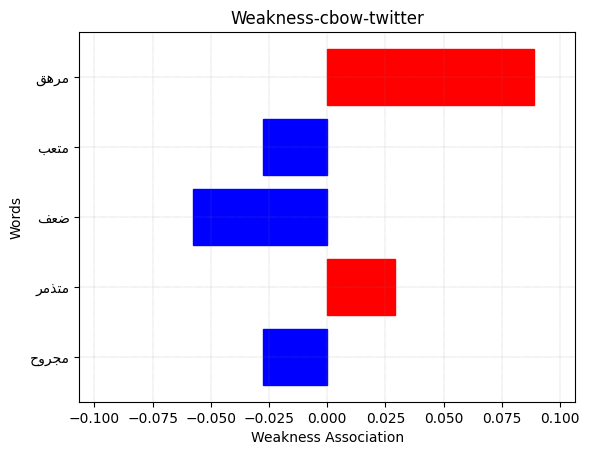

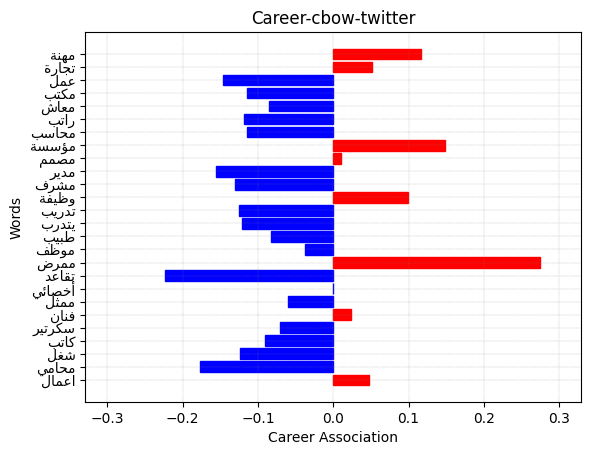

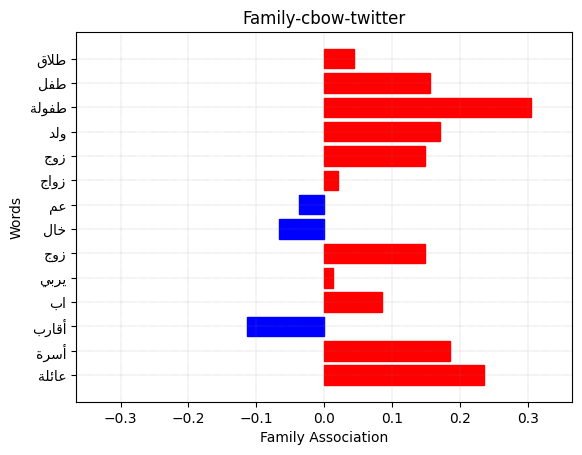

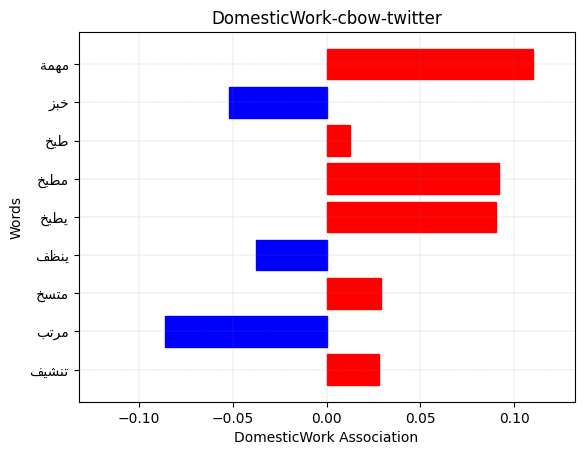

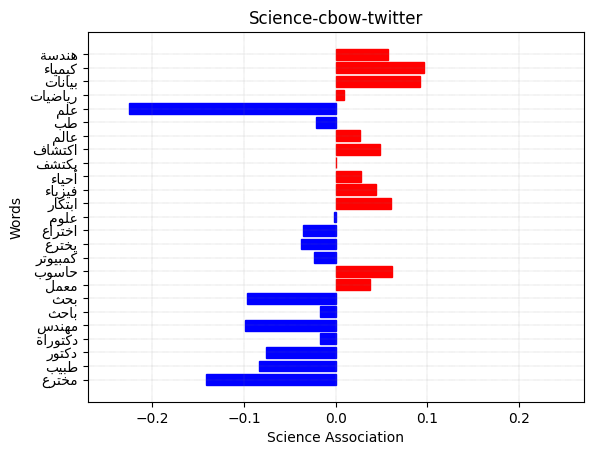

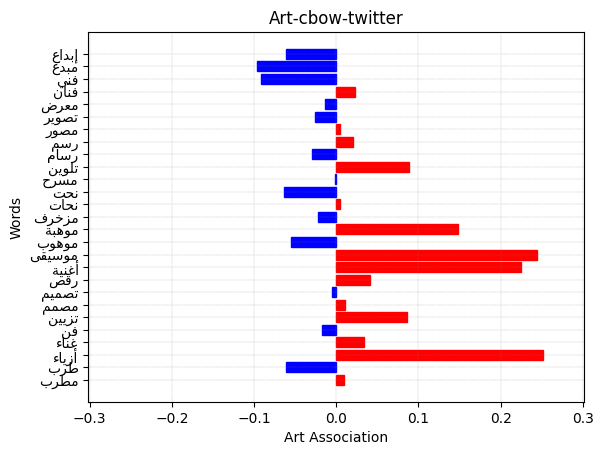

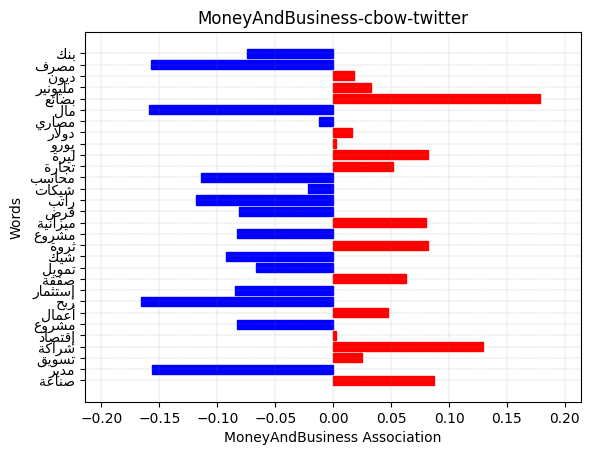

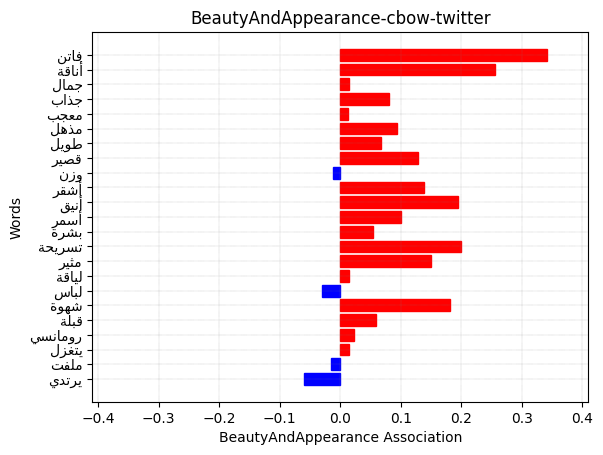

In [21]:
#By Category
for m in models:

        vectors=models[m].wv
        g=gender_vector(nouns,vectors)
        for c in categories:
            location="gender/byCategory/"+c+'-'+m+'.png'
            plotBar(getBias(categories[c]['male'],categories[c]['female'],vectors),categories[c]['male'],c+'-'+m,c+" Association","Words",directory+location)
           


           


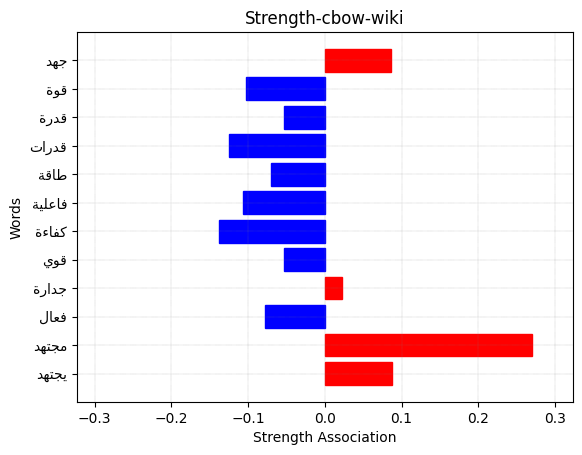

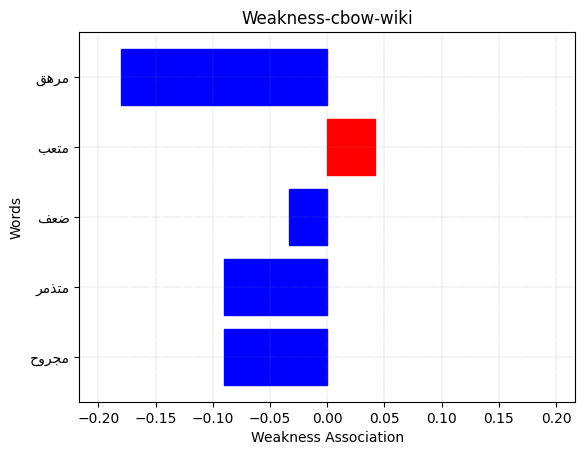

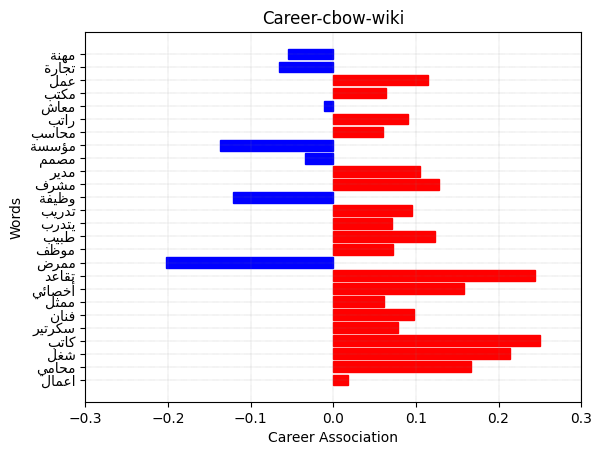

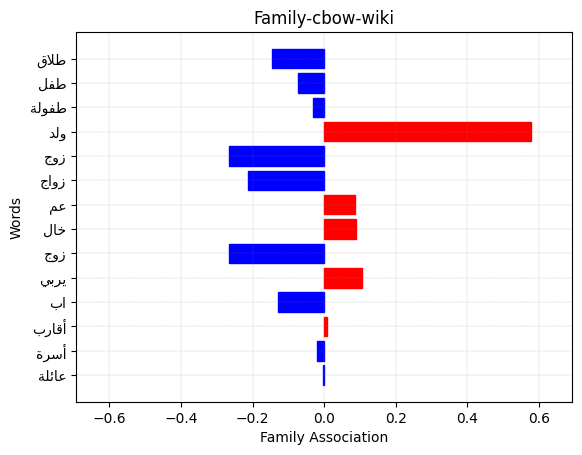

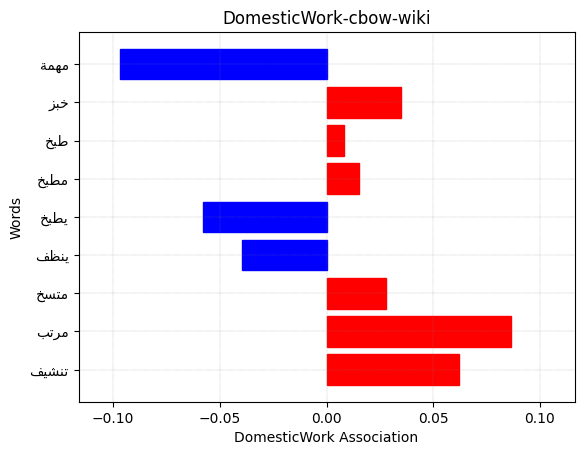

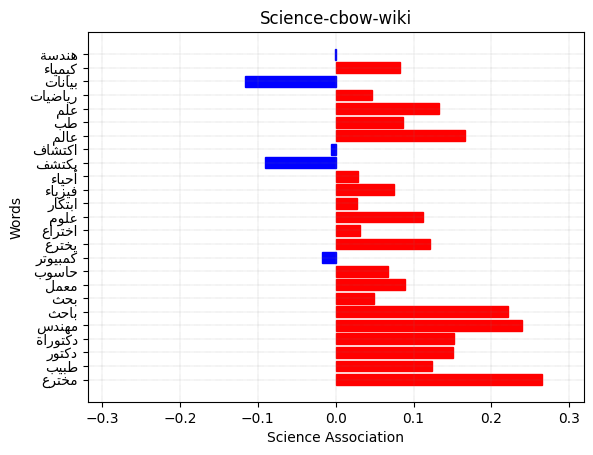

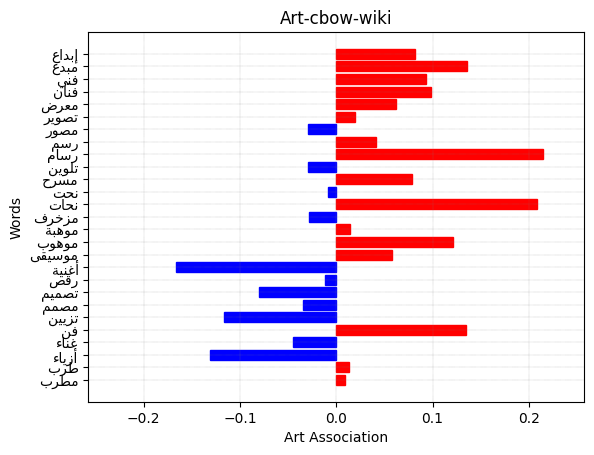

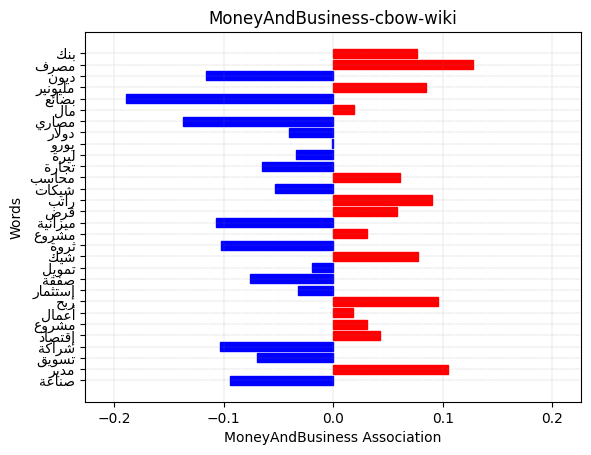

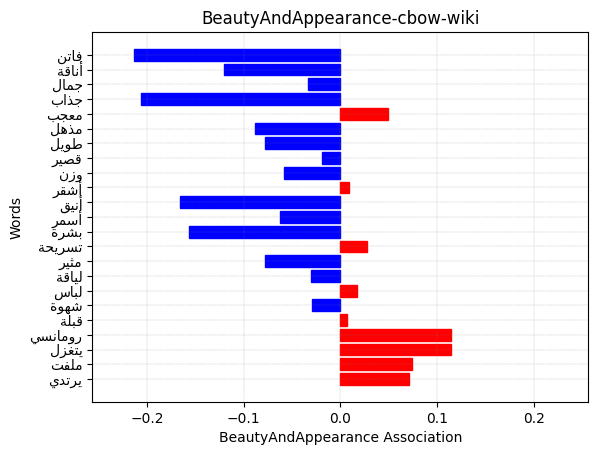

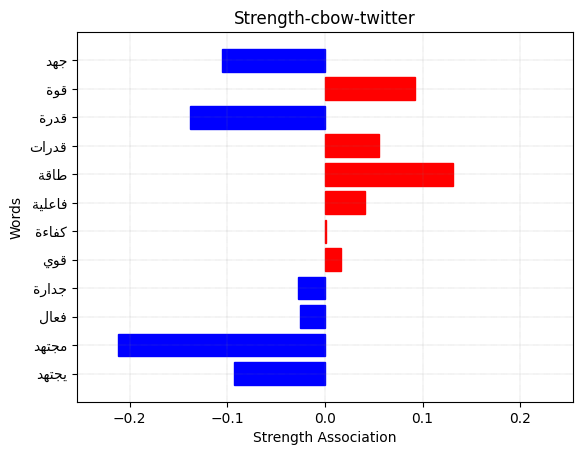

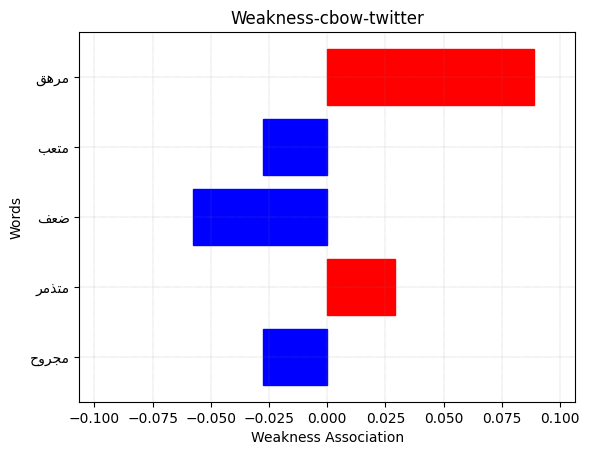

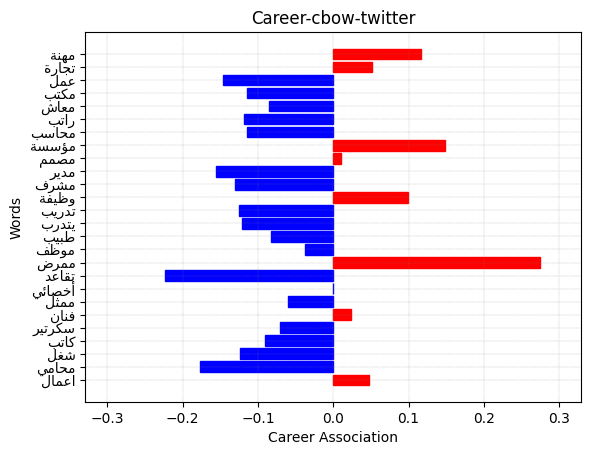

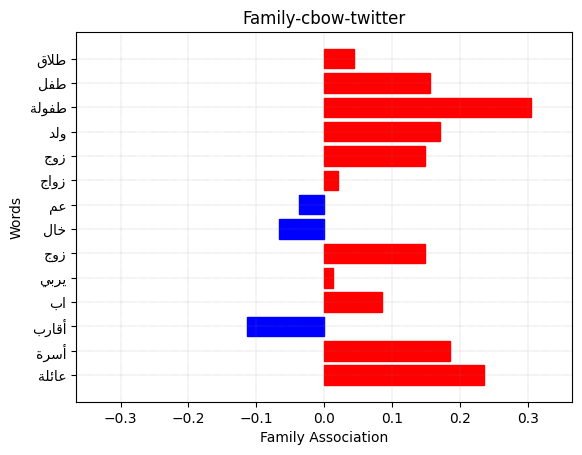

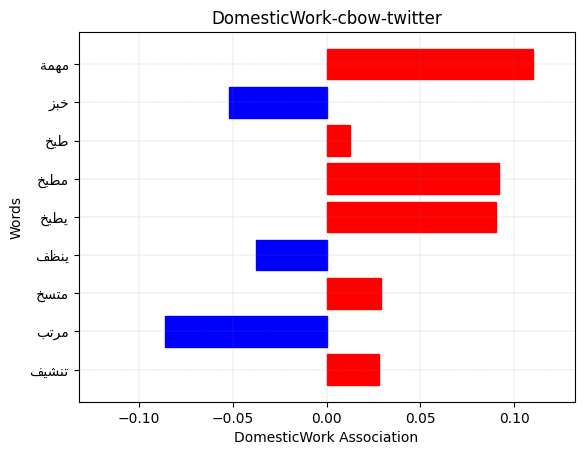

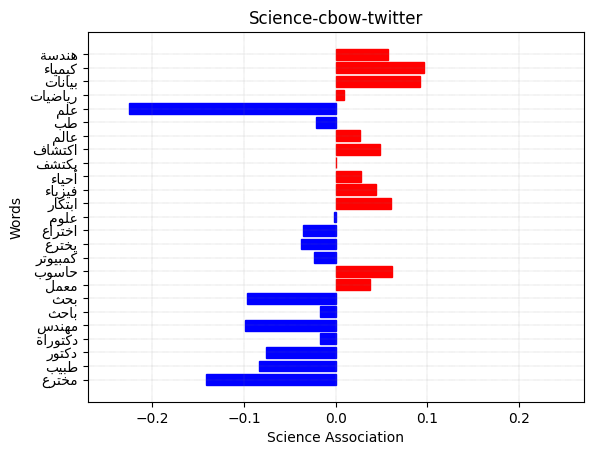

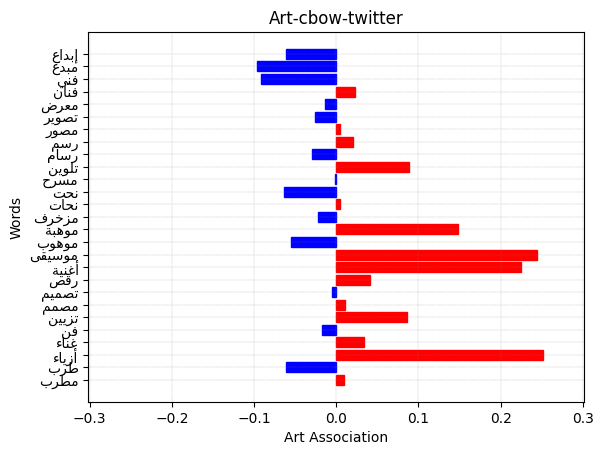

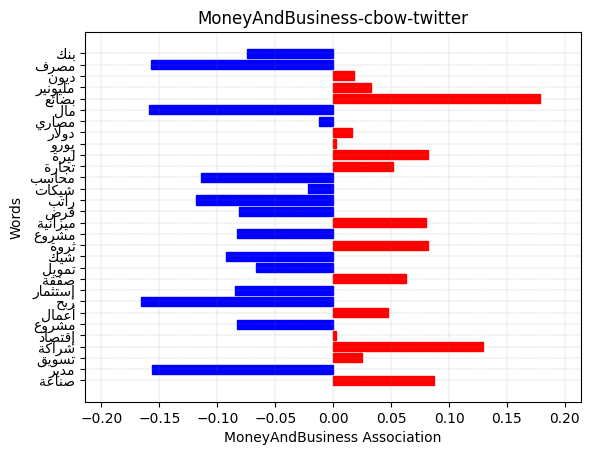

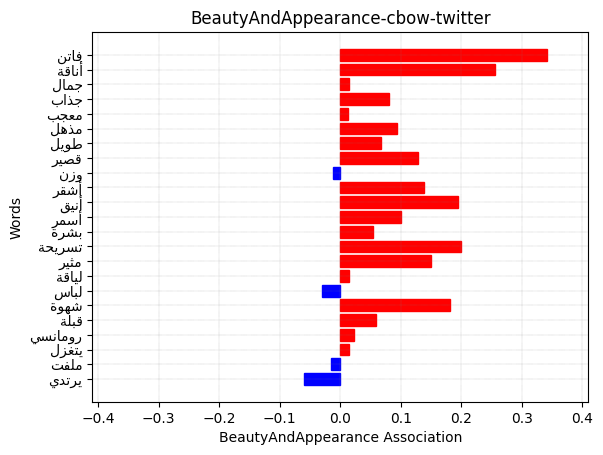

In [22]:
##By model

for m in models:

    vectors=models[m].wv
    g=gender_vector(nouns,vectors)
    for c in categories:
        location="gender/byModel/"+m+'-'+c+'.png'
        plotBar(getBias(categories[c]['male'],categories[c]['female'],vectors),categories[c]['male'],c+'-'+m,c+" Association","Words",directory+location)

#**RUN THE CODE AGAIN WITH THE OTHER ALGORITHM**

######**Load dataframes**

In [23]:


with open(directory+'/cbow.pickle', 'rb') as handle:
    cbow = pickle.load(handle)


In [24]:
df=pd.concat([cbow],ignore_index=True)
display(df)

,Model,Strength,Weakness,Career,Family,DomesticWork,Science,Art,MoneyAndBusiness,BeautyAndAppearance
0,cbow-wiki,-0.021861,-0.052571,0.061083,-0.020131,0.004533,0.081518,0.026094,-0.010699,-0.042158
1,cbow-twitter,-0.021906,0.000923,-0.046532,0.092611,0.020702,-0.012653,0.023859,-0.019126,0.087099


In [25]:
pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
writer = pd.ExcelWriter(directory+"gender/results.xlsx", engine='xlsxwriter')

df.to_excel(writer, sheet_name="models", startrow=0, header=True, index=False)
writer.save()

##Read Excel

In [27]:
directory="/content/drive/My Drive/Research/"
dfs = pd.read_excel(directory+"gender/results.xlsx", sheet_name='models')


In [28]:
cats=list(dfs.columns)[1:13]
cats2=cats.copy()
cats2[4]="D_W"
cats2[7]="M&B"
cats2[8]="B&A"

newcats=[]
for c in range(int(len(cats)/2)):
    newcats.append((cats2[c*2]+" vs "+cats2[c*2+1]))
print(cats2)

['Strength', 'Weakness', 'Career', 'Family', 'D_W', 'Science', 'Art', 'M&B', 'B&A']


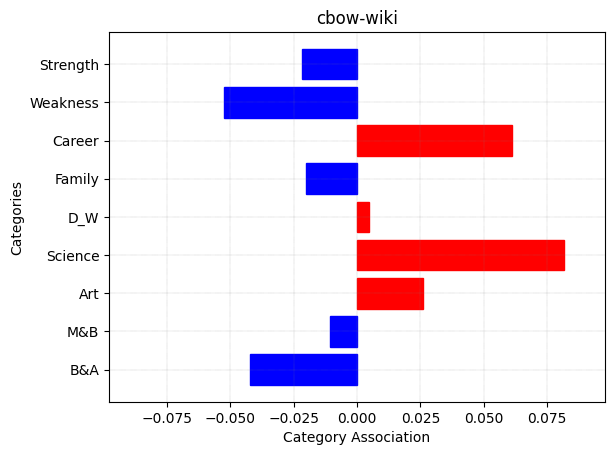

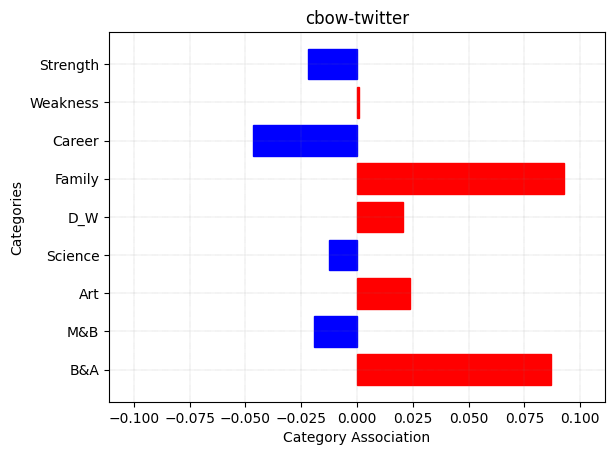

In [29]:
for d in range(len(dfs)):
    row=dfs.iloc[d]
    plotBar(row[1:],cats2,row[0],"Category Association","Categories",directory+'gender/'+row[0]+'.png')